In [1]:
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import random
import time
np.random.seed(42)
random.seed(42)
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
class face:
  def __init__(self, ID, pixels):
    self.ID = ID # each face has an ID corresponding to the individual
    self.pixels = pixels # face is represented by pixels
class person:
  def __init__(self, ID, faces, omega):
    self.ID = ID
    self.faces = faces
    self.omega = omega # class vector

In [3]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
X = lfw_people.data # individuals
for x in X:
  n = np.linalg.norm(x)
  x /= n
y = lfw_people.target # IDs

In [4]:
# sampling randomly
sample_faces, test_faces, sample_ids, test_ids = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
len(sample_faces)

1030

In [6]:
number_of_people = np.unique(sample_ids)

In [7]:
import pandas as pd
df = pd.DataFrame(sample_faces)
df['target'] = sample_ids

sampled_df = df.groupby('target').count()
sampled_df

,0,1,2,3,4,5,6,7,8,9,...,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849
target,,,,,,,,,,,,,,,,,,,,,
0,66,66,66,66,66,66,66,66,66,66,...,66,66,66,66,66,66,66,66,66,66
1,189,189,189,189,189,189,189,189,189,189,...,189,189,189,189,189,189,189,189,189,189
2,99,99,99,99,99,99,99,99,99,99,...,99,99,99,99,99,99,99,99,99,99
3,411,411,411,411,411,411,411,411,411,411,...,411,411,411,411,411,411,411,411,411,411
4,90,90,90,90,90,90,90,90,90,90,...,90,90,90,90,90,90,90,90,90,90
5,58,58,58,58,58,58,58,58,58,58,...,58,58,58,58,58,58,58,58,58,58
6,117,117,117,117,117,117,117,117,117,117,...,117,117,117,117,117,117,117,117,117,117


In [8]:
df = pd.DataFrame(sample_faces)
df['target'] = sample_ids

sampled_df = df.groupby('target').apply(lambda x: x.sample(n=55, random_state=42) if len(x) > 55 else x).reset_index(drop=True)

# Convert the sampled data back to numpy arrays
X_sampled = sampled_df.drop(columns='target').values
y_sampled = sampled_df['target'].values

print(f"Number of images: {len(X_sampled)}")
print(f"Number of labels: {len(np.unique(y_sampled))}")

Number of images: 385
Number of labels: 7


In [9]:
sample_faces = X_sampled
sample_ids = y_sampled

In [10]:
np.unique(sample_ids)

array([0, 1, 2, 3, 4, 5, 6])

In [11]:
j = lfw_people.target_names
print(j)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


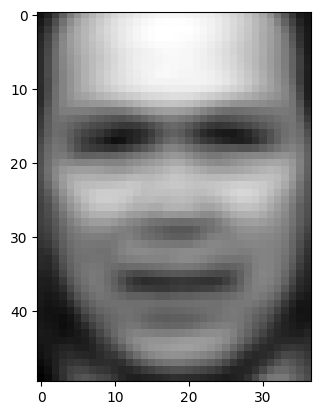

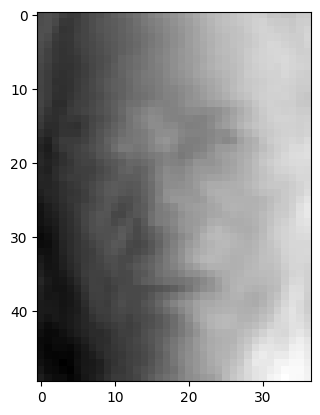

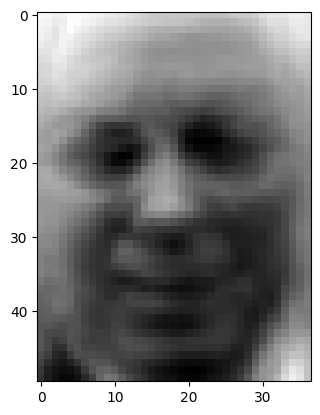

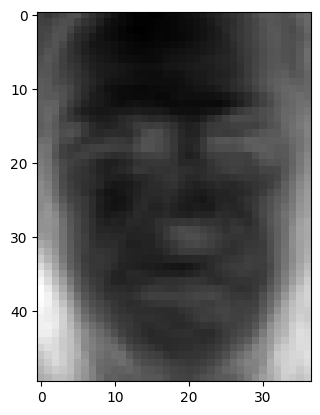

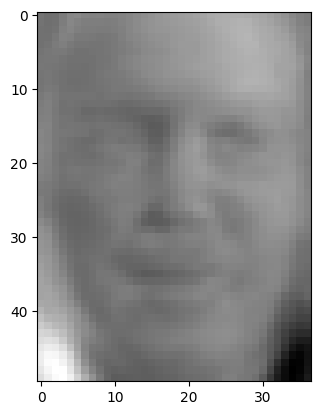

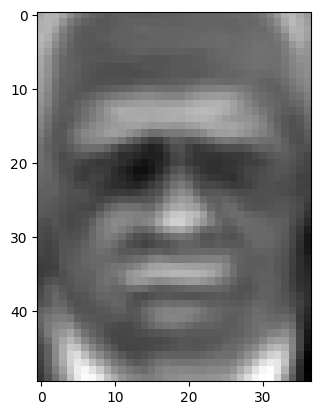

In [12]:
# calculate eigenfaces
M1 = len(sample_faces)
N = sample_faces.shape[1]
m_face = np.mean(sample_faces, axis=0) # mean face
fig = m_face.reshape((50,37))
plt.imshow(fig, cmap=cm.gray)
plt.show()
N = sample_faces.shape[1]
# compute matrix L
Phi = np.zeros(sample_faces.shape)
for i in range(M1):
  Phi[i,:] = m_face
AT = sample_faces - Phi
A = np.transpose(AT)
# we use SVD here
w, s, vh = np.linalg.svd(A)
M3 = 150
eigvals = np.square(s[0:M3]) / M1
eigvecs = np.transpose(w[:,0:M3])
# form eigenfaces
for eigface in eigvecs:
  eigface_norm = np.linalg.norm(eigface)
  eigface /= eigface_norm
for eigface in eigvecs[:5]:
  fig = eigface.reshape((50,37))
  plt.imshow(fig, cmap=cm.gray)
  plt.show()

In [13]:
# calculate class vectors
all_people = []
z = np.zeros(M1)
for i in range(M1):
  if z[i] == 0:
    f = [face(sample_ids[i], sample_faces[i])]
    P = person(sample_ids[i], f, [])
    ID = sample_ids[i]
    for j in range(i+1, M1):
      if ID == sample_ids[j]:
        P.faces.append(face(sample_ids[j], sample_faces[j]))
        z[j] = 1
    all_people.append(P)
for P in all_people:
  omega = np.zeros(M3)
  for face in P.faces:
    for k in range(M3):
      omega[k] = omega[k] + np.matmul(eigvecs[k], face.pixels-m_face)
  omega = omega / len(P.faces)
  P.omega = omega / np.linalg.norm(omega)

In [14]:
for i, p in enumerate(all_people):
  print(i, "th person is", p.ID, p.faces[10].ID)

0 th person is 0 0
1 th person is 1 1
2 th person is 2 2
3 th person is 3 3
4 th person is 4 4
5 th person is 5 5
6 th person is 6 6


In [15]:
# classify unknown faces
# calculate omegas
unknown_omegas = []
for face in test_faces:
  omega = np.zeros(M3)
  for k in range(M3):
    omega[k] = np.matmul(eigvecs[k], face-m_face)
  unknown_omegas.append(omega / np.linalg.norm(omega))

In [16]:
# calculate distances between omegas
correct = 0
c = []
pred = []
for i in range(len(unknown_omegas)):
  u = unknown_omegas[i].flatten()
  dist = []
  for P in all_people:
    d = np.linalg.norm(u-P.omega.flatten())
    dist.append(d)
  d_min = np.amin(dist)
  d_argmin = np.argmin(dist)
  pred.append(all_people[d_argmin].ID)
  if all_people[d_argmin].ID == test_ids[i]:
    correct = correct + 1
    c.append(i)
  if i == 184:
    print(all_people[d_argmin].ID)
accuracy = correct / len(unknown_omegas)

3


In [17]:
correct, len(unknown_omegas)

(130, 258)

In [18]:
print(accuracy)
print(c)

0.5038759689922481
[1, 6, 8, 10, 12, 13, 14, 15, 17, 18, 19, 20, 24, 25, 27, 28, 32, 35, 36, 38, 41, 42, 44, 45, 46, 47, 50, 51, 53, 54, 55, 56, 58, 59, 60, 62, 65, 67, 71, 73, 74, 75, 78, 79, 80, 82, 83, 84, 89, 90, 91, 92, 96, 97, 98, 99, 102, 103, 106, 107, 110, 114, 118, 120, 121, 123, 124, 125, 131, 132, 140, 142, 143, 144, 145, 147, 151, 154, 155, 157, 160, 162, 163, 164, 166, 167, 171, 173, 174, 177, 178, 179, 180, 181, 184, 185, 186, 187, 188, 189, 191, 193, 195, 198, 199, 201, 203, 205, 206, 207, 211, 212, 213, 216, 218, 219, 221, 227, 229, 230, 233, 237, 240, 241, 242, 244, 245, 248, 250, 251]


In [19]:
len(pred) == len(test_ids)

True

In [20]:
for i, name in enumerate(lfw_people.target_names):
  print("Info for", name, "(ids =", i, ")")
  correctLabel = 0
  total = 0
  for t in test_ids:
    if t == i:
      total += 1
  for id in c:
    if test_ids[id] == i:
      correctLabel += 1
  print(correctLabel)
  print(total)
  print("ratio", correctLabel/total)


Info for Ariel Sharon (ids = 0 )
6
11
ratio 0.5454545454545454
Info for Colin Powell (ids = 1 )
20
47
ratio 0.425531914893617
Info for Donald Rumsfeld (ids = 2 )
12
22
ratio 0.5454545454545454
Info for George W Bush (ids = 3 )
61
119
ratio 0.5126050420168067
Info for Gerhard Schroeder (ids = 4 )
12
19
ratio 0.631578947368421
Info for Hugo Chavez (ids = 5 )
8
13
ratio 0.6153846153846154
Info for Tony Blair (ids = 6 )
11
27
ratio 0.4074074074074074


In [21]:
###
print("Info for Sharon (ids=0)")
correctSharon = 0
totalSharon = 0
for j in test_ids:
  if j == 0:
    totalSharon += 1
for i in c:
  if test_ids[i] == 0:
    correctSharon += 1
print(correctSharon)
print(totalSharon)
print("ratio", correctSharon/totalSharon)

###
print("Info for Powell (ids=1)")
correctPowell = 0
totalPowell = 0
for j in test_ids:
  if j == 1:
    totalPowell += 1
for i in c:
  if test_ids[i] == 1:
    correctPowell += 1
print(correctPowell)
print(totalPowell)
print("ratio", correctPowell/totalPowell)

###
print("Info for Rumsfeld (ids=2)")
correctRumsfeld = 0
totalRumsfeld = 0
for j in test_ids:
  if j == 2:
    totalRumsfeld += 1
for i in c:
  if test_ids[i] == 2:
    correctRumsfeld += 1
print(correctRumsfeld)
print(totalRumsfeld)
print("ratio", correctRumsfeld/totalRumsfeld)

###
print("Info for Bush (ids=3)")
correctBush = 0
totalBush = 0
for j in test_ids:
  if j == 3:
    totalBush += 1
for i in c:
  if test_ids[i] == 3:
    correctBush += 1
print(correctBush)
print(totalBush)
print("ratio", correctBush/totalBush)


###
print("Info for Schroder (ids=4)")
correctSchroeder = 0
totalSchroeder = 0
for j in test_ids:
  if j == 4:
    totalSchroeder += 1
for i in c:
  if test_ids[i] == 4:
    correctSchroeder += 1
print(correctSchroeder)
print(totalSchroeder)
print("ratio", correctSchroeder/totalSchroeder)


###
print("Info for Chaves (ids=5)")
correctChavez = 0
totalChavez = 0
for j in test_ids:
  if j == 5:
    totalChavez += 1
for i in c:
  if test_ids[i] == 5:
    correctChavez += 1
print(correctChavez)
print(totalChavez)
print("ratio", correctChavez/totalChavez)


###
print("Info for Blair (ids=6)")
correctBlair = 0
totalBlair = 0
for j in test_ids:
  if j == 6:
    totalBlair += 1
for i in c:
  if test_ids[i] == 6:
    correctBlair += 1
print(correctBlair)
print(totalBlair)
print("ratio", correctBlair/totalBlair)

Info for Sharon (ids=0)
6
11
ratio 0.5454545454545454
Info for Powell (ids=1)
20
47
ratio 0.425531914893617
Info for Rumsfeld (ids=2)
12
22
ratio 0.5454545454545454
Info for Bush (ids=3)
61
119
ratio 0.5126050420168067
Info for Schroder (ids=4)
12
19
ratio 0.631578947368421
Info for Chaves (ids=5)
8
13
ratio 0.6153846153846154
Info for Blair (ids=6)
11
27
ratio 0.4074074074074074


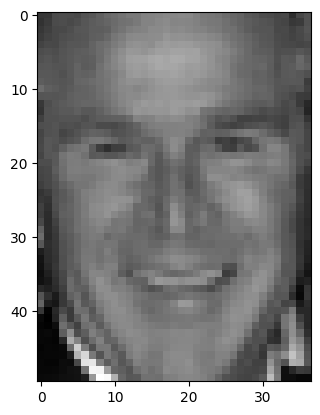

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']
3


In [22]:
f = test_faces[184]
fig = f.reshape((50,37))
plt.imshow(fig, cmap=cm.gray)
plt.show()
j = lfw_people.target_names
print(j)
print(test_ids[184])